In [1]:
# !conda install wget -y

In [11]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

--2020-06-30 18:47:00--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  25.0MB/s    in 3.5s    

2020-06-30 18:47:03 (22.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an a

In [12]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [13]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [4]:
print("x : {}".format(x_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


In [5]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


In [7]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


# 【問題1】BoWのスクラッチ実装
以下の3文のBoWを求められるプログラムをscikit-learnを使わずに作成してください。1-gramと2-gramで計算してください。  

- This movie is SOOOO funny!!!  
- What a movie! I never  
- best movie ever!!!!! this movie  

## ・1-gram

In [8]:
sentence1 = 'This movie is SOOOO funny!!!'.split()
sentence2 = 'What a movie! I never'.split()
sentence3 = 'best movie ever!!!!! this movie'.split()

sentence1 = [s.lower().replace('!', '') for s in sentence1]
sentence2 = [s.lower().replace('!', '') for s in sentence2]
sentence3 = [s.lower().replace('!', '') for s in sentence3]

gram1_words = sentence1 + sentence2 + sentence3

In [9]:
gram_1 = pd.DataFrame(np.zeros((3, len(set(gram1_words)))).astype('int'), columns=set(gram1_words))

gram_1_list = [sentence1, sentence2, sentence3]
for i, ss in enumerate(gram_1_list):
    for s in ss:
        cou = ss.count(s)
        gram_1[s][i] = cou

In [10]:
gram_1

,best,funny,ever,soooo,is,never,this,a,movie,i,what
0,0,1,0,1,1,0,1,0,1,0,0
1,0,0,0,0,0,1,0,1,1,1,1
2,1,0,1,0,0,0,1,0,2,0,0


## ・2-gram

In [11]:
gram2_words  = []
gram_2_list = []
for s in gram_1_list:
    lis = []
    for i in range(len(s)-1):
        gram2_words.append(f'{s[i]} {s[i+1]}')
        lis.append(f'{s[i]} {s[i+1]}')
    
    gram_2_list.append(lis)
    
gram_2_list

[['this movie', 'movie is', 'is soooo', 'soooo funny'],
 ['what a', 'a movie', 'movie i', 'i never'],
 ['best movie', 'movie ever', 'ever this', 'this movie']]

In [12]:
gram_2 = pd.DataFrame(np.zeros((3, len(set(gram2_words)))).astype('int'), columns=set(gram2_words))

for i, ss in enumerate(gram_2_list):
    for s in ss:
        cou = ss.count(s)
        gram_2[s][i] = cou

In [13]:
gram_2

,this movie,movie is,a movie,best movie,is soooo,movie ever,ever this,movie i,soooo funny,i never,what a
0,1,1,0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,0,0,1,0,1,1
2,1,0,0,1,0,1,1,0,0,0,0


# 6.TF-IDF

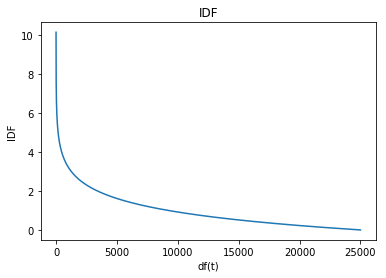

In [14]:
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

In [15]:
mini_dataset

['This movie is very good.',
 'This film is a good',
 'Very bad. Very, very bad.']

In [16]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,movie,this,very
0,0,0,0,1,1,1,1
1,1,0,1,1,0,1,0
2,0,2,0,0,0,0,3


## NLTK

In [17]:
# !conda install nltk -y

In [18]:
# はじめて使う場合はストップワードをダウンロード
import nltk
stop_words = nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',

In [19]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


# 【問題2】TF-IDFの計算
IMDB映画レビューデータセットをTF-IDFによりベクトル化してください。NLTKのストップワードを利用し、最大の語彙数は5000程度に設定してください。テキストクリーニングやステミングなどの前処理はこの問題では要求しません。


TF-IDFの計算にはscikit-learnの以下のどちらかのクラスを使用してください。


[sklearn.feature_extraction.text.TfidfVectorizer — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)  
[sklearn.feature_extraction.text.TfidfTransformer — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
vectorizer_train = TfidfVectorizer(stop_words=stop_words, max_features=5000)
X_train = (vectorizer_train.fit_transform(x_train))
vec = vectorizer_train.get_feature_names()

vectorizer_test = TfidfVectorizer(stop_words=stop_words,
                                  max_features=5000,
                                  vocabulary=vec)
X_test = vectorizer_test.fit_transform(x_test)
print(X_train.shape, X_test.shape)

(25000, 5000) (25000, 5000)


# 【問題3】TF-IDFを用いた学習
問題2で求めたベクトルを用いてIMDB映画レビューデータセットの学習・推定を行なってください。モデルは2値分類が行える任意のものを利用してください。


ここでは精度の高さは求めませんが、最大の語彙数やストップワード、n-gramの数を変化させて影響を検証してみてください。

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.88088

### n-gram数2

In [24]:
vectorizer_train = TfidfVectorizer(stop_words=stop_words,
                                   max_features=5000,
                                   ngram_range=(2, 2))
X_train = (vectorizer_train.fit_transform(x_train))

voc = vectorizer_train.vocabulary_
vectorizer_test = TfidfVectorizer(stop_words=stop_words,
                                  max_features=5000,
                                  vocabulary=voc,
                                  ngram_range=(2, 2))

X_test = vectorizer_test.fit_transform(x_test)
clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.80632

### 正規表現 token_pattern=r'(?u)\b\w+\b'

In [25]:
vectorizer_train = TfidfVectorizer(stop_words=stop_words,
                                   max_features=5000,
                                   token_pattern=r'(?u)\b\w+\b')
X_train = (vectorizer_train.fit_transform(x_train))

voc = vectorizer_train.vocabulary_
vectorizer_test = TfidfVectorizer(stop_words=stop_words,
                                  max_features=5000,
                                  vocabulary=voc,
                                  token_pattern=r'(?u)\b\w+\b')

X_test = vectorizer_test.fit_transform(x_test)
clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.88376

In [26]:
vectorizer_train = TfidfVectorizer(stop_words=stop_words,
                                   max_features=25000,
                                   token_pattern=r'(?u)\b\w+\b')
X_train = (vectorizer_train.fit_transform(x_train))

voc = vectorizer_train.vocabulary_
vectorizer_test = TfidfVectorizer(stop_words=stop_words,
                                  max_features=25000,
                                  vocabulary=voc,
                                  token_pattern=r'(?u)\b\w+\b')

X_test = vectorizer_test.fit_transform(x_test)
clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.88648

# 【問題4】TF-IDFのスクラッチ実装
以下の3文のTF-IDFを求められるプログラムをscikit-learnを使わずに作成してください。標準的な式と、scikit-learnの採用している式の2種類を作成してください。正規化は不要です。

- This movie is SOOOO funny!!!
- What a movie! I never
- best movie ever!!!!! this movie

In [27]:
tf = gram_1.copy()
idf = gram_1.copy()
gram_1

,best,funny,ever,soooo,is,never,this,a,movie,i,what
0,0,1,0,1,1,0,1,0,1,0,0
1,0,0,0,0,0,1,0,1,1,1,1
2,1,0,1,0,0,0,1,0,2,0,0


## 標準的な式

In [28]:
for i in range(len(tf)):
    tf.iloc[i, :] = tf.iloc[i, :] / tf.iloc[i, :].sum()
    
tf

,best,funny,ever,soooo,is,never,this,a,movie,i,what
0,0.0,0.2,0.0,0.2,0.2,0.0,0.2,0.0,0.2,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.2,0.2,0.2
2,0.2,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.4,0.0,0.0


In [29]:
for t in idf.columns:
    idf[t][:] = np.log(len(idf.columns) / idf[t].sum())

idf

,best,funny,ever,soooo,is,never,this,a,movie,i,what
0,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,1.704748,2.397895,1.011601,2.397895,2.397895
1,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,1.704748,2.397895,1.011601,2.397895,2.397895
2,2.397895,2.397895,2.397895,2.397895,2.397895,2.397895,1.704748,2.397895,1.011601,2.397895,2.397895


In [30]:
# TF-IDF
tf * idf

,best,funny,ever,soooo,is,never,this,a,movie,i,what
0,0.000000,0.479579,0.000000,0.479579,0.479579,0.000000,0.34095,0.000000,0.20232,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.479579,0.00000,0.479579,0.20232,0.479579,0.479579
2,0.479579,0.000000,0.479579,0.000000,0.000000,0.000000,0.34095,0.000000,0.40464,0.000000,0.000000


## scikit-learnの採用している式

In [31]:
sk_tf = gram_1.copy()
sk_idf = gram_1.copy()

In [32]:
for t in idf.columns:
    sk_idf[t][:] = np.log((1 + len(sk_idf.columns)) / (1 + idf[t].sum())) + 1
    
sk_idf

,best,funny,ever,soooo,is,never,this,a,movie,i,what
0,1.381543,1.381543,1.381543,1.381543,1.381543,1.381543,1.674285,1.381543,2.089949,1.381543,1.381543
1,1.381543,1.381543,1.381543,1.381543,1.381543,1.381543,1.674285,1.381543,2.089949,1.381543,1.381543
2,1.381543,1.381543,1.381543,1.381543,1.381543,1.381543,1.674285,1.381543,2.089949,1.381543,1.381543


In [33]:
# TF-IDF
sk_tf * sk_idf

,best,funny,ever,soooo,is,never,this,a,movie,i,what
0,0.000000,1.381543,0.000000,1.381543,1.381543,0.000000,1.674285,0.000000,2.089949,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,1.381543,0.000000,1.381543,2.089949,1.381543,1.381543
2,1.381543,0.000000,1.381543,0.000000,0.000000,0.000000,1.674285,0.000000,4.179898,0.000000,0.000000


# 7.Word2Vec

In [14]:
# !pip install gensim

In [7]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'],
             ['this', 'film', 'is', 'a', 'good'],
             ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習
print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
    print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[-0.02938354 -0.00292214 -0.01438889 -0.00901767  0.03570756 -0.04741443
 -0.04971885 -0.00404972 -0.03460984  0.00529867]
movieのベクトル : 
[-0.00476069 -0.01808929  0.03514979  0.03154073 -0.00818305 -0.0205534
 -0.03209094 -0.00772533 -0.04204266 -0.01573867]
isのベクトル : 
[-0.02252607 -0.04631186  0.02279894 -0.01331834 -0.0012428  -0.03476874
  0.03601628  0.03992029  0.03686636  0.04332249]
veryのベクトル : 
[ 0.03757398 -0.02424535 -0.0018553  -0.00064621 -0.04653785  0.04789235
 -0.02705373  0.03759658 -0.04352343 -0.04502432]
goodのベクトル : 
[-0.02292531 -0.04851307  0.00750039 -0.04005523 -0.04164533  0.02595879
  0.03713197  0.00270532  0.01816402  0.04300309]
filmのベクトル : 
[-0.0385631  -0.04310669 -0.00760131 -0.04100683  0.04345412 -0.00728777
  0.02264516  0.02150318 -0.00227737 -0.04927252]
aのベクトル : 
[-0.03453705 -0.01046747  0.04881956  0.0192318   0.01586716  0.04696579
 -0.03770413  0.00495299

In [38]:
model.wv.most_similar(positive="good", topn=3)

[('very', 0.5327800512313843),
 ('bad', 0.06913336366415024),
 ('this', 0.0007879883050918579)]

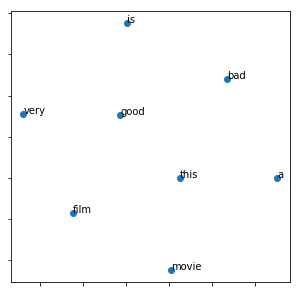

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

# 8.IMDB映画レビューデータセットの分散表現

IMDB映画レビューデータセットの訓練データをコーパスとしてWord2Vecを学習させ分散表現を獲得しましょう。

# 【問題5】コーパスの前処理
コーパスの前処理として、特殊文字（!など）やURLの除去、大文字の小文字化といったことを行なってください。また、単語（トークン）はリストで分割してください。

In [19]:
import re

In [41]:
for i, s in enumerate(x_train):
    if 'http' in s:
        print(i)
        print(s)
        break

38
I don't hand out "ones" often, but if there was ever a film that deserved this sort of attention, it's "Gas!" This is self-indulgent crap that reaches for some of the ambiance of M*A*S*H and falls completely flat on its face in the attempt.<br /><br />I see what Corman was going for - Malcolm Marmorstein and Elliott Gould tried to reproduce Gould's deathless role in the original movie version of M*A*S*H with a similar plot (in the movie "Whiffs" - look it up here in IMDb, http://www.imdb.com/title/tt0073891/ for more information).<br /><br />Marmorstein and Gould got closer to the brass ring with "Whiffs" than Corman did with "Gas!" but didn't quite get there. Neither one of those films even got close to the success of M*A*S*H.<br /><br />What's wrong with "Gas!"? What isn't? No one comes close to really acting at a level above junior high school theatrics. The production values stink. Someone else here mentioned the magically regenerating headlights on a getaway car, and there's mo

In [42]:
sentence = x_train[38]
sentence = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', "", sentence) #　url削除
sentence = re.sub(r'<[^>]+>', " ", sentence) # htmlタグ削除
sentence = re.sub(r"[^0-9a-zA-Z ]", "", sentence) # 英数字、空白以外削除

sentence = sentence.lower() # 小文字化
sentence

'i dont hand out ones often but if there was ever a film that deserved this sort of attention its gas this is selfindulgent crap that reaches for some of the ambiance of mash and falls completely flat on its face in the attempt  i see what corman was going for  malcolm marmorstein and elliott gould tried to reproduce goulds deathless role in the original movie version of mash with a similar plot in the movie whiffs  look it up here in imdb  for more information  marmorstein and gould got closer to the brass ring with whiffs than corman did with gas but didnt quite get there neither one of those films even got close to the success of mash  whats wrong with gas what isnt no one comes close to really acting at a level above junior high school theatrics the production values stink someone else here mentioned the magically regenerating headlights on a getaway car and theres more of that lack of attention to detail nothing works the way its supposed to in this film and nobody cares  gas actu

In [20]:
def get_corpus(data):
    sentence = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', "", data) #　url削除
    sentence = re.sub(r'<[^>]+>', "", sentence) # htmlタグ削除
    sentence = re.sub(r"[^0-9a-zA-Z ]", "", sentence) # 英数字、空白以外削除

    sentence = sentence.lower() # 小文字化
    sentence = sentence.split()
    return sentence

In [21]:
X_train = []
X_test = []
for ss in x_train:
    X_train.append(get_corpus(ss))
    
for ss in x_test:
    X_test.append(get_corpus(ss))

# 【問題6】Word2Vecの学習
Word2Vecの学習を行なってください。

In [45]:
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(X_train[:100]) # 準備
model.train(X_train, total_examples=model.corpus_count, epochs=model.iter) # 学習
# print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
# for vocab in model.wv.vocab.keys():
#     print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

(17032324, 28595085)

# 【問題7】（アドバンス課題）ベクトルの可視化
得られたベクトルをt-SNEにより可視化してください。また、いくつかの単語を選びwv.most_similarを用いて似ている単語を調べてください。

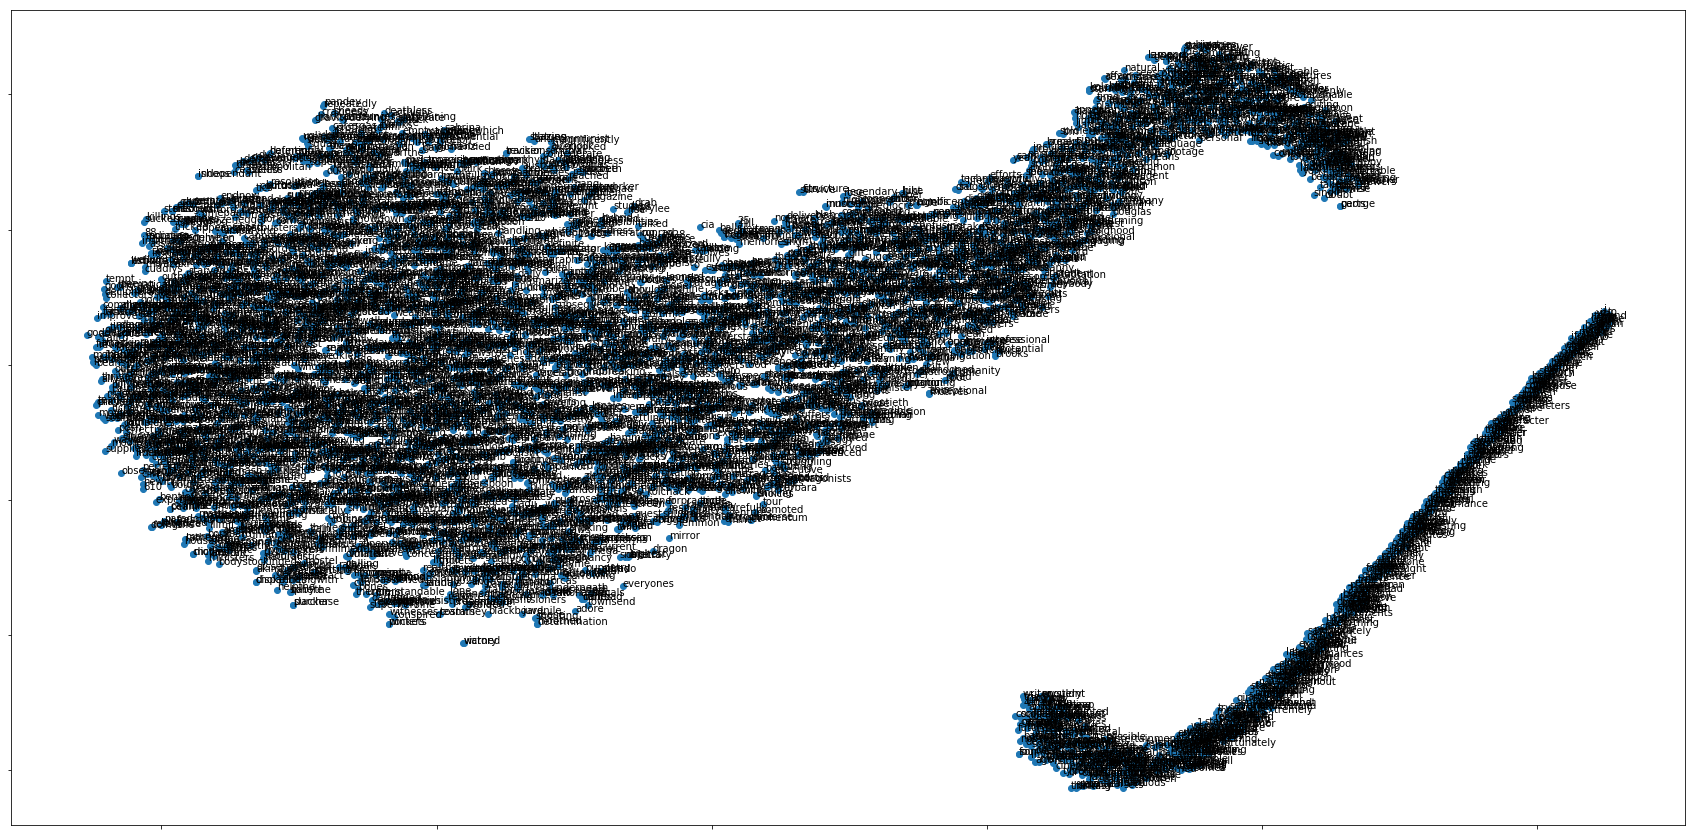

In [46]:
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(30,15))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [47]:
model.wv.most_similar(positive="good", topn=5)

[('take', 0.9999443292617798),
 ('they', 0.9999262690544128),
 ('very', 0.9999029040336609),
 ('well', 0.9998961687088013),
 ('really', 0.999874472618103)]

In [48]:
model.wv.most_similar(positive="bad", topn=5)

[('not', 0.9998010993003845),
 ('funny', 0.9997714757919312),
 ('modern', 0.9997535943984985),
 ('just', 0.9997456073760986),
 ('it', 0.9997295141220093)]

In [49]:
model.wv.most_similar(positive="movie", topn=5)

[('film', 0.9998137950897217),
 ('was', 0.9996931552886963),
 ('seeing', 0.9996708035469055),
 ('city', 0.9996175765991211),
 ('time', 0.9996119737625122)]

In [50]:
model.wv.most_similar(positive="film", topn=5)

[('movie', 0.9998137950897217),
 ('is', 0.999786376953125),
 ('real', 0.9997832775115967),
 ('character', 0.9997708797454834),
 ('movies', 0.9997323751449585)]

# 【問題8】（アドバンス課題）Word2Vecを用いた映画レビューの分類
問題6で学習して得たベクトルや公開されている学習済みベクトルを用いてIMDB映画レビューデータセットの感情分類の学習・推定を行なってください。

- I don't hand out "ones" often, but if.....
- (-1, ベクトル×単語数）
- 単語数を揃える。短い文章はパディング


In [72]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target

In [73]:
X_train = []
X_test = []
for ss in x_train:
    X_train.append(get_corpus(ss))
    
for ss in x_test:
    X_test.append(get_corpus(ss))

## ・ロジステッィッック回帰

In [53]:
model = Word2Vec(min_count=1, size=1000)
model.build_vocab(X_train) # 準備
model.train(X_train, total_examples=model.corpus_count, epochs=model.iter) # 学習

(21756776, 28595085)

In [54]:
X = X_train.copy()
y = y_train.copy()

In [56]:
X_data = np.zeros((25000, 1000))
for i, ss in enumerate(X):
    l = len(ss)
    vec = np.zeros(1000)
    for s in ss:
        vec += model.wv[s]/l
    
    X_data[i, :] = vec

In [57]:
X_tr, X_val, y_tr, y_val = train_test_split(X_data, y, test_size=0.2, stratify=y, random_state=123)

In [58]:
clf = LogisticRegression()
clf.fit(X_tr, y_tr)
pred = clf.predict(X_val)
clf.score(X_val, y_val)

0.8442

## ・CNN

In [74]:
size=100
model = Word2Vec(min_count=1, size=size) # 次元数を10に設定
model.build_vocab(X_train) # 準備
model.train(X_train, total_examples=model.corpus_count, epochs=model.iter) # 学習

(21756797, 28595085)

In [75]:
X = X_train.copy()
y = y_train.copy()

In [76]:
X_data = []
for ss in X:
    l = []
    for s in ss[:size]:
        l.append(model.wv[s].tolist())
    
    X_data.append(l)

In [77]:
x = np.zeros((len(X_data), size, size))
for i in range(len(X_data)):
    x[i, :len(X_data[i])] = np.array(X_data[i])

In [78]:
x.shape

(25000, 100, 100)

In [79]:
x = x.reshape(-1, size, size, 1)

In [80]:
x.shape

(25000, 100, 100, 1)

In [81]:
X_tr, X_val, y_tr, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=123)

In [82]:
import tensorflow as tf
from tensorflow.keras import layers
from keras import backend as K

In [87]:
K.clear_session()

model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 1)))
model.add(layers.Conv2D(16, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()
model.compile(loss="binary_crossentropy",
              optimizer=tf.train.AdamOptimizer(learning_rate=0.0001),
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1179680   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,184,657
Trainable params: 1,184,657
Non-trainable params: 0
______________________________________________

In [88]:
history = model.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val],
                    batch_size=20,
                    epochs=10,
                    verbose=True)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 17s 840us/sample - loss: 0.6488 - acc: 0.6117 - val_loss: 0.5537 - val_acc: 0.7316
Epoch 2/10
20000/20000 [==============================] - 16s 824us/sample - loss: 0.5147 - acc: 0.7509 - val_loss: 0.5246 - val_acc: 0.7344
Epoch 3/10
20000/20000 [==============================] - 16s 825us/sample - loss: 0.4594 - acc: 0.7833 - val_loss: 0.4935 - val_acc: 0.7562
Epoch 4/10
20000/20000 [==============================] - 16s 825us/sample - loss: 0.4232 - acc: 0.8066 - val_loss: 0.4979 - val_acc: 0.7580
Epoch 5/10
20000/20000 [==============================] - 16s 822us/sample - loss: 0.3882 - acc: 0.8286 - val_loss: 0.5394 - val_acc: 0.7424
Epoch 6/10
20000/20000 [==============================] - 16s 823us/sample - loss: 0.3532 - acc: 0.8450 - val_loss: 0.5157 - val_acc: 0.7550
Epoch 7/10
20000/20000 [==============================] - 17s 828us/sample - loss: 0.3169 - acc: 0.8694 -